In [44]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import jv, jn_zeros
import matplotlib.pyplot as plt

In [26]:
class ParametricEigenSolver:
    """
    Solves eigenvalue problems by approximating eigenfunctions as:
    f(x) = sum_i [a_i*sin(k_i*x) + b_i*cos(k_i*x)]
    
    Uses fixed frequencies k_i and optimizes coefficients a_i, b_i
    """
    
    def __init__(self, L, x_points, n_frequencies=10):
        """
        Parameters:
        -----------
        L : ndarray (N, N)
            The matrix for eigenvalue problem
        x_points : ndarray (N,)
            The discrete points where eigenfunction is evaluated
        n_frequencies : int
            Number of frequency components to use
        """
        self.L = L
        self.x_points = x_points
        self.N = len(x_points)
        self.n_freq = n_frequencies
        
        # Fixed frequencies: k = π, 2π, 3π, ... on the domain
        x_range = x_points[-1] - x_points[0]
        self.frequencies = np.array([k * np.pi / x_range for k in range(1, n_frequencies + 1)])
        
        self.eigenpairs = []  # List of (lambda, coeffs, u)
        
        # Precompute basis functions
        self._compute_basis()
        
    def _compute_basis(self):
        """Precompute sin and cos basis functions at all x_points"""
        self.basis_sin = np.zeros((self.n_freq, self.N))
        self.basis_cos = np.zeros((self.n_freq, self.N))
        
        for i, k in enumerate(self.frequencies):
            self.basis_sin[i, :] = np.sin(k * self.x_points)
            self.basis_cos[i, :] = np.cos(k * self.x_points)
    
    def eigenfunction(self, coeffs):
        """
        Evaluate f(x) = sum_i [a_i*sin(k_i*x) + b_i*cos(k_i*x)]
        
        Parameters:
        -----------
        coeffs : array of length 2*n_freq
            [a_1, a_2, ..., a_n, b_1, b_2, ..., b_n]
        """
        n = self.n_freq
        a = coeffs[:n]
        b = coeffs[n:]
        
        u = np.zeros(self.N)
        for i in range(n):
            u += a[i] * self.basis_sin[i, :] + b[i] * self.basis_cos[i, :]
        
        return u
    
    def orthogonalize(self, u):
        """Make u orthogonal to all previously found eigenfunctions"""
        u_orth = u.copy()
        for _, _, prev_u in self.eigenpairs:
            proj = np.dot(u_orth, prev_u)
            u_orth = u_orth - proj * prev_u
        
        # Normalize
        norm_u = np.linalg.norm(u_orth)
        if norm_u > 1e-10:
            u_orth = u_orth / norm_u
        return u_orth
    
    def objective_rayleigh(self, coeffs):
        """
        Objective using Rayleigh quotient: minimize residual ||Lu - λu||
        where λ = u^T L u / ||u||^2
        """
        # Evaluate eigenfunction
        u = self.eigenfunction(coeffs)
        
        # Orthogonalize against previous eigenfunctions
        u = self.orthogonalize(u)
        
        # Avoid trivial solution
        norm_u = np.linalg.norm(u)
        if norm_u < 1e-8:
            return 1e10
        
        u = u / norm_u
        
        # Compute Rayleigh quotient
        Lu = self.L @ u
        lam = np.dot(u, Lu)
        
        # Compute residual
        residual = Lu - lam * u
        return np.linalg.norm(residual)**2
    
    def find_eigenfunction(self, initial_guess=None):
        """
        Find one eigenpair by optimization
        
        Returns:
        --------
        lambda : float
            Eigenvalue
        coeffs : array
            Coefficients
        u : array
            Eigenfunction evaluated at x_points
        """
        n_params = 2 * self.n_freq
        
        if initial_guess is None:
            # Random initialization
            initial_guess = np.random.randn(n_params) * 0.1
        
        # Optimize
        result = minimize(self.objective_rayleigh, initial_guess, 
                         method='L-BFGS-B',
                         options={'maxiter': 3000, 'ftol': 1e-10})
        
        coeffs = result.x
        u = self.eigenfunction(coeffs)
        u = self.orthogonalize(u)
        u = u / np.linalg.norm(u)
        
        # Compute eigenvalue via Rayleigh quotient
        Lu = self.L @ u
        lam = np.dot(u, Lu)
        
        print(f"Found eigenvalue: λ = {lam:.6f}, residual = {result.fun:.2e}")
        
        return lam, coeffs, u
    
    def find_n_eigenfunctions(self, n, num_attempts=3):
        """
        Find n eigenpairs using multiple random initializations
        """
        for i in range(n):
            print(f"\n--- Finding eigenfunction {i+1}/{n} ---")
            
            best_result = None
            best_residual = float('inf')
            
            # Try multiple initializations
            for attempt in range(num_attempts):
                prev_eigenpairs = self.eigenpairs.copy()
                
                try:
                    lam, coeffs, u = self.find_eigenfunction()
                    
                    # Check residual
                    Lu = self.L @ u
                    residual_vec = Lu - lam * u
                    residual = np.linalg.norm(residual_vec)**2
                    
                    if residual < best_residual:
                        best_residual = residual
                        best_result = (lam, coeffs, u)
                    
                    # Restore state
                    self.eigenpairs = prev_eigenpairs
                    
                except Exception as e:
                    print(f"  Attempt {attempt+1} failed: {e}")
                    self.eigenpairs = prev_eigenpairs
            
            if best_result is not None:
                lam, coeffs, u = best_result
                self.eigenpairs.append((lam, coeffs, u))
                print(f"  Best residual: {best_residual:.2e}")
            else:
                print(f"  Failed to find eigenfunction {i+1}")
        
        # Sort by eigenvalue
        self.eigenpairs.sort(key=lambda x: x[0])
        print("\n=== Sorted eigenvalues ===")
        for i, (lam, _, _) in enumerate(self.eigenpairs):
            print(f"Mode {i+1}: λ = {lam:.6f}")
    
    def plot_eigenfunctions(self, figsize=(12, 8)):
        """Plot all found eigenfunctions"""
        n_eigen = len(self.eigenpairs)
        if n_eigen == 0:
            print("No eigenfunctions found yet!")
            return
        
        fig, axes = plt.subplots(n_eigen, 1, figsize=figsize, squeeze=False)
        
        for i, (lam, coeffs, u) in enumerate(self.eigenpairs):
            ax = axes[i, 0]
            ax.plot(self.x_points, u, 'b-', linewidth=2)
            ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
            ax.set_ylabel(f'u_{i+1}(x)')
            ax.set_title(f'Eigenfunction {i+1}: λ = {lam:.6f}')
            ax.grid(True, alpha=0.3)
            
            if i == n_eigen - 1:
                ax.set_xlabel('x')
        
        plt.tight_layout()
        plt.show()
    
    def verify_orthogonality(self):
        """Check orthogonality of found eigenfunctions"""
        n = len(self.eigenpairs)
        if n < 2:
            print("Need at least 2 eigenfunctions to check orthogonality")
            return
        
        print("\nOrthogonality matrix (should be close to identity):")
        ortho_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                u_i = self.eigenpairs[i][2]
                u_j = self.eigenpairs[j][2]
                ortho_matrix[i, j] = np.dot(u_i, u_j)
        
        print(ortho_matrix)
        return ortho_matrix


In [27]:
# Setup problem
N = 50

# Create 1D Laplacian matrix (discrete -d²/dx²)
L = np.zeros((N, N))
for i in range(N):
    L[i, i] = 2
    if i > 0:
        L[i, i-1] = -1
    if i < N-1:
        L[i, i+1] = -1

# Define x points (equidistant on [0, π])
x_points = np.linspace(0, np.pi, N)


--- Finding eigenfunction 1/10 ---
Found eigenvalue: λ = 0.237976, residual = 4.28e-08
Found eigenvalue: λ = 0.094117, residual = 5.51e-07
Found eigenvalue: λ = 0.183070, residual = 4.02e-08
Found eigenvalue: λ = 0.367639, residual = 8.20e-06
Found eigenvalue: λ = 0.183069, residual = 5.70e-09
Found eigenvalue: λ = 0.183070, residual = 5.60e-08
Found eigenvalue: λ = 0.237976, residual = 7.54e-08
Found eigenvalue: λ = 0.237976, residual = 9.20e-08
Found eigenvalue: λ = 0.094116, residual = 7.97e-08
Found eigenvalue: λ = 0.299569, residual = 1.18e-06
Found eigenvalue: λ = 0.060407, residual = 1.78e-06
Found eigenvalue: λ = 0.060407, residual = 1.11e-06
Found eigenvalue: λ = 0.237976, residual = 3.31e-07
Found eigenvalue: λ = 0.237976, residual = 2.39e-07
Found eigenvalue: λ = 0.237976, residual = 3.69e-07
Found eigenvalue: λ = 0.094116, residual = 3.53e-07
Found eigenvalue: λ = 0.183070, residual = 8.99e-08
Found eigenvalue: λ = 0.135057, residual = 1.37e-06
Found eigenvalue: λ = 0.2379

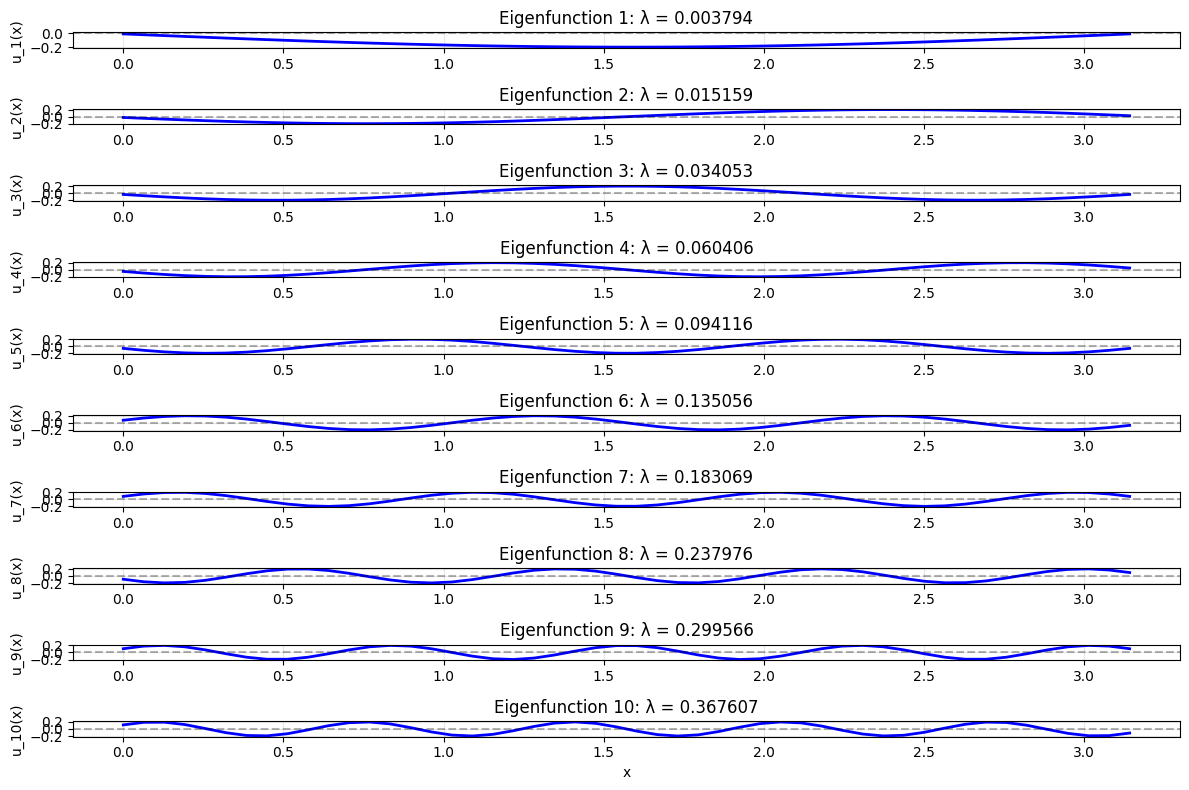

In [28]:
# Create solver
solver = ParametricEigenSolver(L, x_points)

# Find first 3 eigenfunctions
solver.find_n_eigenfunctions(n=10, num_attempts=100)

# Verify orthogonality
solver.verify_orthogonality()

# Plot results
solver.plot_eigenfunctions()

In [30]:
# Compare with true eigenvalues (for Laplacian, λ_k ≈ 4*sin²(kπ/(2N)))
print("\nComparison with theoretical eigenvalues (1D Laplacian):")
for i, (lam, _, _) in enumerate(solver.eigenpairs):
    k = i + 1
    theoretical = 4 * np.sin(k * np.pi / (2 * N))**2
    print(f"  Mode {k}: Found λ={lam:.6f}, Theory λ={theoretical:.6f}")


Comparison with theoretical eigenvalues (1D Laplacian):
  Mode 1: Found λ=0.003794, Theory λ=0.003947
  Mode 2: Found λ=0.015159, Theory λ=0.015771
  Mode 3: Found λ=0.034053, Theory λ=0.035425
  Mode 4: Found λ=0.060406, Theory λ=0.062834
  Mode 5: Found λ=0.094116, Theory λ=0.097887
  Mode 6: Found λ=0.135056, Theory λ=0.140447
  Mode 7: Found λ=0.183069, Theory λ=0.190346
  Mode 8: Found λ=0.237976, Theory λ=0.247387
  Mode 9: Found λ=0.299566, Theory λ=0.311344
  Mode 10: Found λ=0.367607, Theory λ=0.381966


In [39]:
class ParametricEigenSolver2D:
    """
    Solves 2D eigenvalue problems by approximating eigenfunctions as:
    f(x,y) = sum_{m,n} a_{mn}*sin(k_m*x)*sin(k_n*y) + b_{mn}*cos(k_m*x)*cos(k_n*y)
              + c_{mn}*sin(k_m*x)*cos(k_n*y) + d_{mn}*cos(k_m*x)*sin(k_n*y)
    
    For polar coordinates (circle):
    f(r,θ) = sum_{m,n} [a_{mn}*J_m(k_n*r)*sin(m*θ) + b_{mn}*J_m(k_n*r)*cos(m*θ)]
    where J_m are Bessel functions
    """
    
    def __init__(self, L, points, domain='square', n_frequencies=5):
        """
        Parameters:
        -----------
        L : ndarray (N, N)
            The matrix for eigenvalue problem (N = total number of grid points)
        points : tuple or ndarray
            For square: (x_points, y_points) - both 1D arrays
            For circle: (r_points, theta_points, mask) - polar coordinates + mask for valid points
        domain : str
            'square' or 'circle'
        n_frequencies : int
            Number of frequency components in each direction
        """
        self.L = L
        self.domain = domain
        self.n_freq = n_frequencies
        self.eigenpairs = []
        
        if domain == 'square':
            self.x_points, self.y_points = points
            self.nx = len(self.x_points)
            self.ny = len(self.y_points)
            self.N = self.nx * self.ny
            
            # Create 2D meshgrid
            self.X, self.Y = np.meshgrid(self.x_points, self.y_points, indexing='ij')
            
            # Fixed frequencies
            x_range = self.x_points[-1] - self.x_points[0]
            y_range = self.y_points[-1] - self.y_points[0]
            self.freq_x = np.array([k * np.pi / x_range for k in range(1, n_frequencies + 1)])
            self.freq_y = np.array([k * np.pi / y_range for k in range(1, n_frequencies + 1)])
            
            self._compute_basis_square()
            
        elif domain == 'circle':
            self.r_points, self.theta_points, self.mask = points
            self.nr = len(self.r_points)
            self.ntheta = len(self.theta_points)
            self.N = np.sum(self.mask)  # Only count valid points inside circle
            
            # Create polar meshgrid
            self.R, self.Theta = np.meshgrid(self.r_points, self.theta_points, indexing='ij')
            
            # Zeros of Bessel functions for radial modes
            self.bessel_zeros = {m: jn_zeros(m, n_frequencies) for m in range(n_frequencies)}
            
            self._compute_basis_circle()
    
    def _compute_basis_square(self):
        """Precompute 2D basis functions for square domain"""
        self.basis_functions = []
        for kx in self.freq_x:
            for ky in self.freq_y:
                self.basis_functions.append((np.sin(kx*self.X) * np.sin(ky*self.Y)).flatten())
                self.basis_functions.append((np.cos(kx*self.X) * np.cos(ky*self.Y)).flatten())
                self.basis_functions.append((np.sin(kx*self.X) * np.cos(ky*self.Y)).flatten())
                self.basis_functions.append((np.cos(kx*self.X) * np.sin(ky*self.Y)).flatten())
        self.n_basis = len(self.basis_functions)
    
    def _compute_basis_circle(self):
        """Precompute basis functions for circular domain using Bessel functions"""
        self.basis_functions = []
        r_max = self.r_points[-1]
        for m in range(self.n_freq):
            for n_idx in range(self.n_freq):
                k_mn = self.bessel_zeros[m][n_idx] / r_max
                basis_sin = jv(m, k_mn*self.R) * np.sin(m*self.Theta)
                self.basis_functions.append(basis_sin[self.mask])
                if m > 0:
                    basis_cos = jv(m, k_mn*self.R) * np.cos(m*self.Theta)
                    self.basis_functions.append(basis_cos[self.mask])
        self.n_basis = len(self.basis_functions)
    
    def eigenfunction(self, coeffs):
        """Evaluate eigenfunction as linear combination of basis functions"""
        u = np.zeros(self.N)
        for i, c in enumerate(coeffs):
            u += c * self.basis_functions[i]
        return u
    
    def orthogonalize(self, u):
        """Make u orthogonal to all previously found eigenfunctions"""
        u_orth = u.copy()
        for _, _, prev_u in self.eigenpairs:
            u_orth -= np.dot(u_orth, prev_u) * prev_u
        norm_u = np.linalg.norm(u_orth)
        return u_orth / norm_u if norm_u > 1e-10 else u_orth
    
    def objective_rayleigh(self, coeffs):
        u = self.eigenfunction(coeffs)
        u = self.orthogonalize(u)
        norm_u = np.linalg.norm(u)
        if norm_u < 1e-8:
            return 1e10
        u /= norm_u
        Lu = self.L @ u
        lam = np.dot(u, Lu)
        return np.linalg.norm(Lu - lam*u)**2
    
    def find_eigenfunction(self, initial_guess=None):
        if initial_guess is None:
            initial_guess = np.random.randn(self.n_basis) * 0.1
        result = minimize(self.objective_rayleigh, initial_guess, method='L-BFGS-B',
                          options={'maxiter':3000, 'ftol':1e-10})
        coeffs = result.x
        u = self.eigenfunction(coeffs)
        u = self.orthogonalize(u)
        u /= np.linalg.norm(u)
        lam = np.dot(u, self.L @ u)
        print(f"Found eigenvalue: λ = {lam:.6f}, residual = {result.fun:.2e}")
        return lam, coeffs, u
    
    def find_n_eigenfunctions(self, n, num_attempts=3):
        for i in range(n):
            best_result = None
            best_residual = float('inf')
            for _ in range(num_attempts):
                prev_eigenpairs = self.eigenpairs.copy()
                try:
                    lam, coeffs, u = self.find_eigenfunction()
                    residual = np.linalg.norm(self.L @ u - lam*u)**2
                    if residual < best_residual:
                        best_residual = residual
                        best_result = (lam, coeffs, u)
                    self.eigenpairs = prev_eigenpairs
                except:
                    self.eigenpairs = prev_eigenpairs
            if best_result:
                self.eigenpairs.append(best_result)
        self.eigenpairs.sort(key=lambda x: x[0])
        print("=== Sorted eigenvalues ===")
        for i, (lam, _, _) in enumerate(self.eigenpairs):
            print(f"Mode {i+1}: λ = {lam:.6f}")
    
    def plot_eigenfunctions(self, figsize=(15,10)):
        n_eigen = len(self.eigenpairs)
        if n_eigen == 0:
            print("No eigenfunctions found yet!")
            return
        ncols = min(3, n_eigen)
        nrows = (n_eigen + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
        for idx, (lam, coeffs, u) in enumerate(self.eigenpairs):
            row, col = divmod(idx, ncols)
            ax = axes[row, col]
            if self.domain == 'square':
                u2d = u.reshape(self.nx, self.ny)
                im = ax.contourf(self.X, self.Y, u2d, levels=20, cmap='RdBu_r')
            elif self.domain == 'circle':
                u2d = np.zeros_like(self.R)
                u2d[self.mask] = u
                Xc = self.R*np.cos(self.Theta)
                Yc = self.R*np.sin(self.Theta)
                u_plot = np.ma.masked_where(~self.mask, u2d)
                im = ax.contourf(Xc, Yc, u_plot, levels=20, cmap='RdBu_r')
                ax.set_aspect('equal')
            ax.set_title(f'Mode {idx+1}: λ={lam:.4f}')
            plt.colorbar(im, ax=ax)
        for idx in range(n_eigen, nrows*ncols):
            row, col = divmod(idx, ncols)
            axes[row, col].axis('off')
        plt.tight_layout()
        plt.show()
    
    def verify_orthogonality(self):
        n = len(self.eigenpairs)
        if n < 2:
            print("Need at least 2 eigenfunctions to check orthogonality")
            return
        ortho = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                ortho[i,j] = np.dot(self.eigenpairs[i][2], self.eigenpairs[j][2])
        print("Orthogonality matrix:")
        print(ortho)
        return ortho


2D SQUARE DOMAIN - LAPLACIAN
Found eigenvalue: λ = 0.622776, residual = 3.37e-05
Found eigenvalue: λ = 0.622761, residual = 1.12e-05
Found eigenvalue: λ = 0.731970, residual = 1.09e-05
Found eigenvalue: λ = 0.436367, residual = 4.93e-06
Found eigenvalue: λ = 0.545643, residual = 7.10e-06
Found eigenvalue: λ = 0.545612, residual = 5.39e-06
Found eigenvalue: λ = 0.731970, residual = 1.19e-05
Found eigenvalue: λ = 0.545652, residual = 7.23e-06
Found eigenvalue: λ = 0.436379, residual = 6.38e-06
Found eigenvalue: λ = 0.622761, residual = 1.17e-05
Found eigenvalue: λ = 0.695069, residual = 4.25e-06
Found eigenvalue: λ = 1.067818, residual = 2.75e-05
Found eigenvalue: λ = 0.695078, residual = 6.76e-06
Found eigenvalue: λ = 0.881430, residual = 1.27e-05
Found eigenvalue: λ = 0.731969, residual = 1.04e-05
Found eigenvalue: λ = 0.545630, residual = 6.17e-06
Found eigenvalue: λ = 0.731968, residual = 1.57e-05
Found eigenvalue: λ = 0.731971, residual = 1.23e-05
Found eigenvalue: λ = 0.731972, re

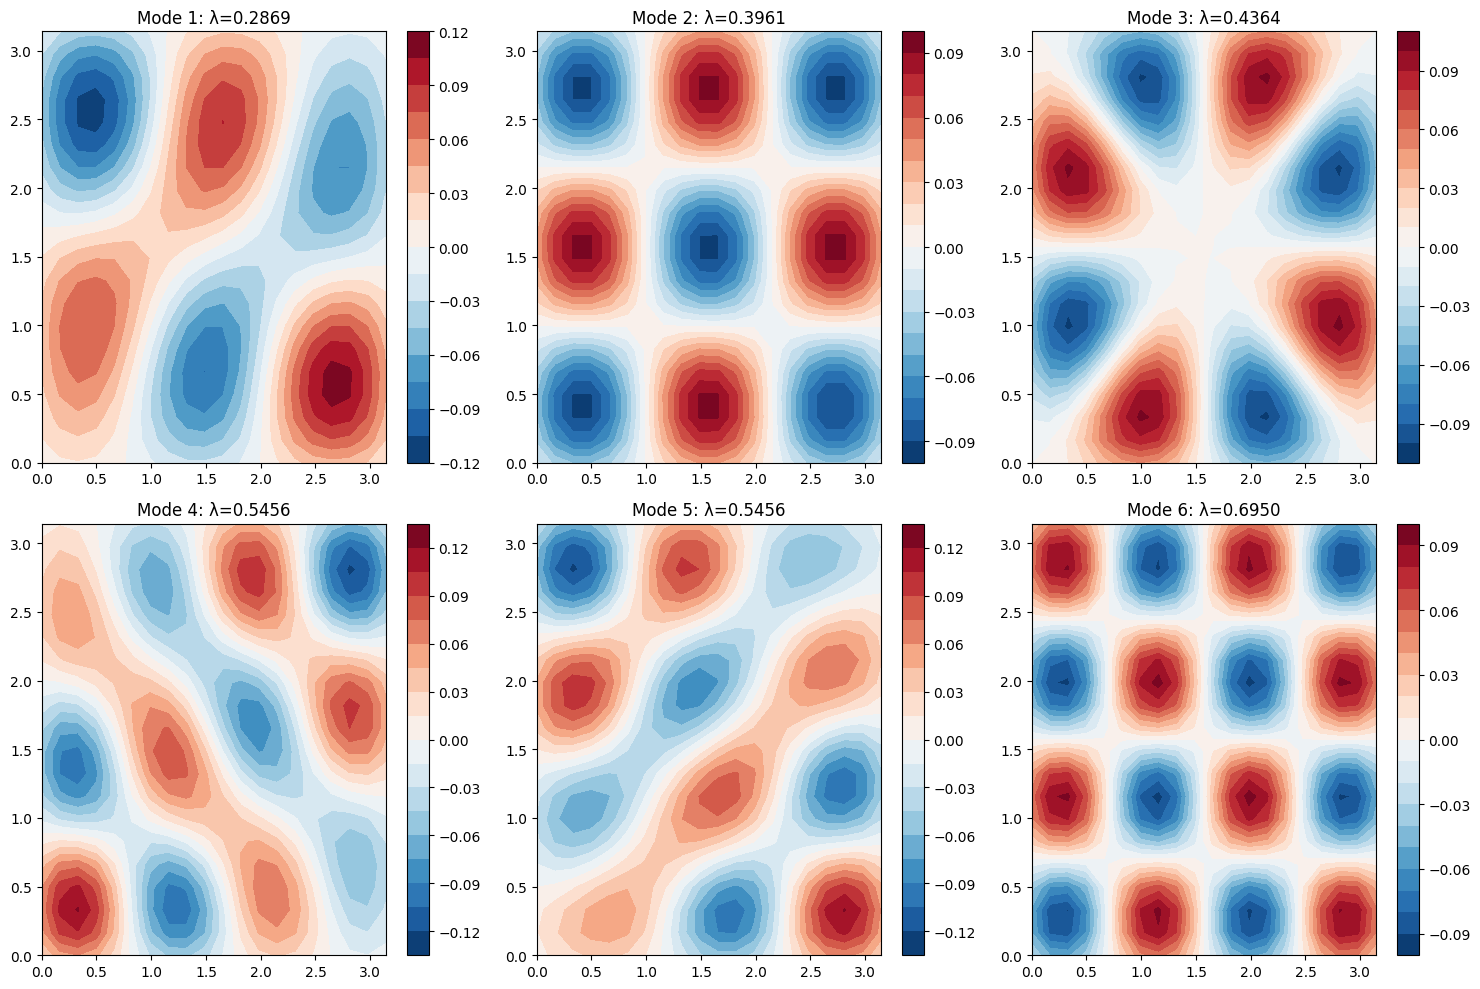


Theoretical eigenvalues for 2D square Laplacian:
λ(m,n) ≈ (m²+n²)π²/L² where m,n are mode numbers


In [46]:
print("\n" + "="*60)
print("2D SQUARE DOMAIN - LAPLACIAN")
print("="*60)

# Create 2D Laplacian on square domain
nx, ny = 20, 20
N_2d = nx * ny

# Build 2D Laplacian matrix (5-point stencil)
L_2d = np.zeros((N_2d, N_2d))

def idx(i, j):
    """Convert 2D index to 1D"""
    return i * ny + j

for i in range(nx):
    for j in range(ny):
        k = idx(i, j)
        L_2d[k, k] = 4
        if i > 0:
            L_2d[k, idx(i-1, j)] = -1
        if i < nx-1:
            L_2d[k, idx(i+1, j)] = -1
        if j > 0:
            L_2d[k, idx(i, j-1)] = -1
        if j < ny-1:
            L_2d[k, idx(i, j+1)] = -1

x_2d = np.linspace(0, np.pi, nx)
y_2d = np.linspace(0, np.pi, ny)

solver_2d_square = ParametricEigenSolver2D(L=L_2d, points=(x_2d, y_2d), domain='square', n_frequencies=5)

solver_2d_square.find_n_eigenfunctions(n=6, num_attempts=50)
solver_2d_square.plot_eigenfunctions()

print("\nTheoretical eigenvalues for 2D square Laplacian:")
print("λ(m,n) ≈ (m²+n²)π²/L² where m,n are mode numbers")

In [51]:
from scipy.linalg import eigh

# Given 2D Laplacian setup
nx, ny = 20, 20
N_2d = nx * ny

L_2d = np.zeros((N_2d, N_2d))

def idx(i, j):
    return i * ny + j

for i in range(nx):
    for j in range(ny):
        k = idx(i, j)
        L_2d[k, k] = 4
        if i > 0:
            L_2d[k, idx(i-1, j)] = -1
        if i < nx-1:
            L_2d[k, idx(i+1, j)] = -1
        if j > 0:
            L_2d[k, idx(i, j-1)] = -1
        if j < ny-1:
            L_2d[k, idx(i, j+1)] = -1

# Compute all eigenvalues
eigvals = eigh(L_2d, eigvals_only=True)

# Print first 6 eigenvalues
eigvals[10:20]

array([0.39612453, 0.43637684, 0.43637684, 0.54558472, 0.54558472,
       0.5562346 , 0.5562346 , 0.62275064, 0.62275064, 0.6950449 ])


2D CIRCULAR DOMAIN - LAPLACIAN
Found eigenvalue: λ = 21.839182, residual = 3.85e+02
Found eigenvalue: λ = 21.839180, residual = 3.85e+02
Found eigenvalue: λ = 21.839178, residual = 3.85e+02
Found eigenvalue: λ = 21.839197, residual = 3.85e+02
Found eigenvalue: λ = 21.839176, residual = 3.85e+02
Found eigenvalue: λ = 21.839140, residual = 3.85e+02
Found eigenvalue: λ = 33.567786, residual = 5.45e+02
Found eigenvalue: λ = 33.567842, residual = 5.45e+02
Found eigenvalue: λ = 33.567789, residual = 5.45e+02
Found eigenvalue: λ = 33.567870, residual = 5.45e+02
Found eigenvalue: λ = 33.567779, residual = 5.45e+02
Found eigenvalue: λ = 33.567842, residual = 5.45e+02
Found eigenvalue: λ = 49.001522, residual = 7.68e+02
Found eigenvalue: λ = 49.001530, residual = 7.68e+02
Found eigenvalue: λ = 49.001421, residual = 7.68e+02
Found eigenvalue: λ = 49.001461, residual = 7.68e+02
Found eigenvalue: λ = 49.001446, residual = 7.68e+02
Found eigenvalue: λ = 49.001501, residual = 7.68e+02
=== Sorted eig

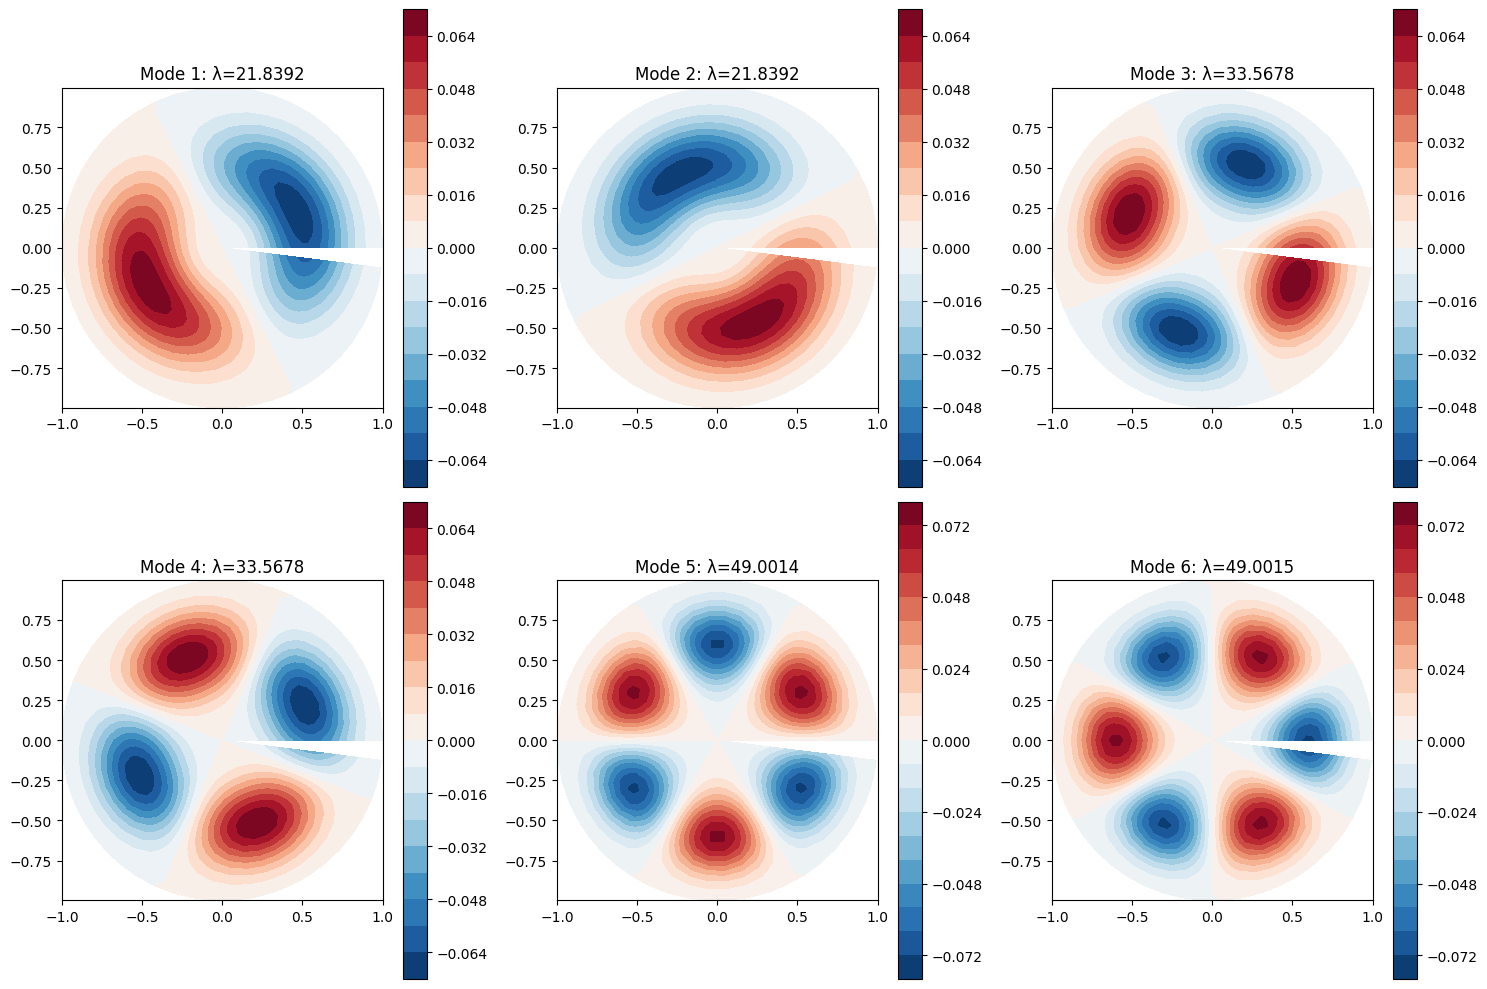


Theoretical: Circle eigenvalues involve Bessel function zeros
First few: λ ≈ 5.78, 14.68, 26.37, ...


In [45]:
print("\n" + "="*60)
print("2D CIRCULAR DOMAIN - LAPLACIAN")
print("="*60)

# Create 2D Laplacian on circular domain
nr, ntheta = 25, 50
r_max = 1.0
r_points = np.linspace(0, r_max, nr)
theta_points = np.linspace(0, 2*np.pi, ntheta, endpoint=False)

# Create mask for points inside circle
R_grid, Theta_grid = np.meshgrid(r_points, theta_points, indexing='ij')
mask = R_grid <= r_max

# Build Laplacian in polar coordinates (simplified)
N_circle = np.sum(mask)
L_circle = np.zeros((N_circle, N_circle))

# Map 2D indices to 1D for valid points
idx_map = np.zeros((nr, ntheta), dtype=int)
idx_map.fill(-1)
counter = 0
for i in range(nr):
    for j in range(ntheta):
        if mask[i, j]:
            idx_map[i, j] = counter
            counter += 1

# Build Laplacian (simplified finite difference)
dr = r_points[1] - r_points[0] if nr > 1 else 1
dtheta = theta_points[1] - theta_points[0] if ntheta > 1 else 1

for i in range(nr):
    for j in range(ntheta):
        if not mask[i, j]:
            continue
        
        k = idx_map[i, j]
        r = r_points[i]
        
        if r < 1e-10:  # Special case at origin
            L_circle[k, k] = 4
            if i+1 < nr and mask[i+1, j]:
                L_circle[k, idx_map[i+1, j]] = -1
        else:
            # ∇²u = ∂²u/∂r² + (1/r)∂u/∂r + (1/r²)∂²u/∂θ²
            
            # Radial part
            L_circle[k, k] += 2 / dr**2
            if i > 0 and mask[i-1, j]:
                L_circle[k, idx_map[i-1, j]] = -1/dr**2 - 1/(2*r*dr)
            if i+1 < nr and mask[i+1, j]:
                L_circle[k, idx_map[i+1, j]] = -1/dr**2 + 1/(2*r*dr)
            
            # Angular part
            L_circle[k, k] += 2 / (r**2 * dtheta**2)
            j_minus = (j - 1) % ntheta
            j_plus = (j + 1) % ntheta
            if mask[i, j_minus]:
                L_circle[k, idx_map[i, j_minus]] = -1 / (r**2 * dtheta**2)
            if mask[i, j_plus]:
                L_circle[k, idx_map[i, j_plus]] = -1 / (r**2 * dtheta**2)

solver_2d_circle = ParametricEigenSolver2D(
    L_circle, (r_points, theta_points, mask),
    domain='circle', n_frequencies=4
)

solver_2d_circle.find_n_eigenfunctions(n=6, num_attempts=3)
solver_2d_circle.plot_eigenfunctions()

print("\nTheoretical: Circle eigenvalues involve Bessel function zeros")
print("First few: λ ≈ 5.78, 14.68, 26.37, ...")
